# 學習日期: 2022/6/2開始
## 目標: 使用指定的backbone論文，進行口罩辨識
## Backbone論文: Network in Network
- **參考資料1:** https://hackmd.io/@shaoeChen/HJ19NfW4U
- **參考資料2:** https://github.com/jiecaoyu/pytorch-nin-cifar10
- **長青自製-口罩數據集:** https://drive.google.com/drive/folders/1lC_BVKHzEbtMEy8tibXAsJdrAs6fWuz5?usp=sharing


## 0_修改程式 (傳送門)
- [1_設定參數](#1_設定參數)


- [2.1_資料前處理-transform](#2.1_資料前處理-transform)


- [2.2_資料前處理-資料分割方式](#2.2_資料前處理-資料分割方式)


- [3.1_查看model參數量](#3.1_查看model參數量)


- [3.2_訓練模型(train,val)](#3.2_訓練模型(train,val))


- [3.3_model初始化權重](#3.3_model初始化權重)


- [4_運行主程式](#4_運行主程式)


- [5_查看訓練結果](#5_查看訓練結果(僅顯示最後一個Fold))


## [資料集說明]
### 1. choose_data_split = 'original':
    |-- data (放dataset資料夾)
        |-- train
            |-- class_0
            |-- class_1
            |-- class_2
            |-- class_3
        |-- val
            |-- class_0
            |-- class_1
            |-- class_2
            |-- class_3
            
### 2. choose_data_split = 'K_fold':
    |-- data_kfold (放dataset資料夾)
        |-- class_0
        |-- class_1
        |-- class_2
        |-- class_3

## [Visdom訓練過程即時可視化說明]
### 1. 先終端機輸入:
- `conda activate Py37` -- {environment name}
- `python -m visdom.server -port 8097` -- {port number}

### 2. 再網頁輸入:
- `http://localhost:8097`

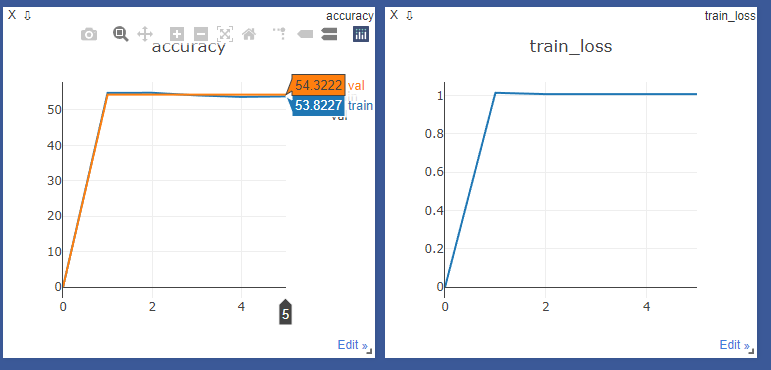

In [1]:
import torch, os
from torch.utils.data import DataLoader, SubsetRandomSampler, Subset
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from torch import optim  # 調整學習率更新策略
import visdom  # 訓練即時可視化工具
from tqdm import tqdm  # 訓練進度條
from torchinfo import summary  # 顯示model參數量、model大小
from sklearn.model_selection import KFold  # K_fold交叉驗證
from NIN_v1_model import NIN_v1  # 載入我的model
from NIN_v2_model import NIN_v2
from NIN_v3_model import NIN_v3
from InceptionV3_model import Inception

Conv2d output shape: 	 torch.Size([1, 192, 224, 224])
ReLU output shape: 	 torch.Size([1, 192, 224, 224])
Conv2d output shape: 	 torch.Size([1, 160, 224, 224])
ReLU output shape: 	 torch.Size([1, 160, 224, 224])
Conv2d output shape: 	 torch.Size([1, 96, 224, 224])
ReLU output shape: 	 torch.Size([1, 96, 224, 224])
MaxPool2d output shape: 	 torch.Size([1, 96, 112, 112])
Dropout output shape: 	 torch.Size([1, 96, 112, 112])
Conv2d output shape: 	 torch.Size([1, 192, 112, 112])
ReLU output shape: 	 torch.Size([1, 192, 112, 112])
Conv2d output shape: 	 torch.Size([1, 192, 112, 112])
ReLU output shape: 	 torch.Size([1, 192, 112, 112])
Conv2d output shape: 	 torch.Size([1, 192, 112, 112])
ReLU output shape: 	 torch.Size([1, 192, 112, 112])
AvgPool2d output shape: 	 torch.Size([1, 192, 56, 56])
Dropout output shape: 	 torch.Size([1, 192, 56, 56])
Conv2d output shape: 	 torch.Size([1, 192, 56, 56])
ReLU output shape: 	 torch.Size([1, 192, 56, 56])
Conv2d output shape: 	 torch.Size([1, 192, 56,

## 1_設定參數

In [2]:
# 設定參數--------------------------------------------------------------------
batch_size = 16
img_size = 224  # 設定圖片resize大小
lr = 0.01  # 學習率
epoch = 3
use_GPU = True  # 是否使用GPU訓練
real_time_train_result = False  # 若不想開啟Visdom，就設為"False"
optim = 'SGD'  # 優化器: SGD, Adam
choose_model = 'NIN_v3'  # 模型: NIN_v1, NIN_v2, NIN_v3, Inception
choose_data_split, split_num = 'K_fold', 5  # 驗證方式: original(data=data), K_fold(data=data_kfold)
pooling = 'avg'  # NIN_v3專用: max, avg

MODEL = 'best_model.pth'  # 保存model名稱
classes = {0: 'cloth_mask', 1: 'face_no_mask', 2:'mask_surgical'}  # 設定dataset classes類別

# 強迫固定初始權重，方便研究用
np.random.seed(0)
torch.manual_seed(0)

## 2.1_資料前處理-transform

In [3]:
# 資料前處理
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

transform_train = transforms.Compose([
    transforms.Resize((img_size,img_size)), # 強制224x224
    #transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

transform_val = transforms.Compose([
    transforms.Resize((img_size,img_size)), #長=256 寬=等比例縮小
    #transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    normalize
])

## 2.2_資料前處理-資料分割方式
- **K-fold:**
    - 解釋: https://ithelp.ithome.com.tw/articles/10278851
    - 寫法教學: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md

In [4]:
# 方法一: 資料夾先分好
if choose_data_split == 'original':
    train_data = datasets.ImageFolder('data/train/', transform=transform_train)
    trainloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)  # shuffle: 每次batch_size取不同dataset
    val_data = datasets.ImageFolder('data/val/', transform=transform_val)
    valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    
    print("訓練張數有: ", len(trainloader.dataset))
    print("驗證張數有: ", len(valloader.dataset))
    print("在此batch_size下，trainloader跌帶次數: ", len(trainloader))
    print("在此batch_size下，valloader跌帶次數: ", len(valloader))
    
# 方法二: K_fold方式 (資料夾未先分train, val)
elif choose_data_split == 'K_fold':
    train_data = datasets.ImageFolder('data_kfold/', transform=transform_train)
    
    # 設定交叉驗證區分幾塊
    K_fold = KFold(n_splits = split_num, shuffle=True, random_state=42)
    
    # 方便觀察用，真正使用會在後面"迴圈主程式"，位置擺在for i in epoch的外層
    for K_fold_num, (train_idx, valid_idx) in enumerate(K_fold.split(train_data)):  # k_fold分割方式 -> (train, val)
        print(f'K_fold: {K_fold_num}')
        fack_train_sampler = SubsetRandomSampler(train_idx)  # 打亂id (1,2,3,4) -> (3,1,,4,2)
        fack_valid_sampler = SubsetRandomSampler(valid_idx)
        fack_trainloader = DataLoader(train_data, batch_size=batch_size, sampler=fack_train_sampler, shuffle=False)  # 有sampler就不會有shuffle
        fack_valloader = DataLoader(train_data, batch_size=batch_size, sampler=fack_valid_sampler, shuffle=False)

    print("\n訓練張數有: ", len(fack_train_sampler))  # !!注意:這裡不能用trainloader_datasets
    print("驗證張數有: ", len(fack_valid_sampler))
    print("在此batch_size下，trainloader跌帶次數: ", len(fack_trainloader))
    print("在此batch_size下，valloader跌帶次數: ", len(fack_valloader))
    

K_fold: 0
K_fold: 1
K_fold: 2
K_fold: 3
K_fold: 4

訓練張數有:  4026
驗證張數有:  1006
在此batch_size下，trainloader跌帶次數:  252
在此batch_size下，valloader跌帶次數:  63


## 3.1_查看model參數量

In [5]:
# 選擇查看模型
#choose_model = 'NIN_v1'  # 快速查看
if choose_model == 'NIN_v1':
    model = NIN_v1(num_classes=len(classes))
elif choose_model == 'NIN_v2':
    model = NIN_v2(num_classes=len(classes))
elif choose_model == 'NIN_v3':
    model = NIN_v3(pooling= pooling, num_classes=len(classes))
elif choose_model == 'Inception':
    model = Inception(pretrained=0, num_classes=len(classes))
model_parameter = summary(model, input_size=(batch_size, 3, img_size, img_size))  # 算出model parm
print("我選擇的模型: ", choose_model,"\n")
print(model_parameter)

我選擇的模型:  NIN_v3 

Layer (type:depth-idx)                   Output Shape              Param #
NIN_v3                                   [16, 3]                   --
├─Sequential: 1-1                        [16, 3]                   --
│    └─Conv2d: 2-1                       [16, 96, 54, 54]          34,944
│    └─ReLU: 2-2                         [16, 96, 54, 54]          --
│    └─Conv2d: 2-3                       [16, 96, 54, 54]          9,312
│    └─ReLU: 2-4                         [16, 96, 54, 54]          --
│    └─Conv2d: 2-5                       [16, 96, 54, 54]          9,312
│    └─ReLU: 2-6                         [16, 96, 54, 54]          --
│    └─AvgPool2d: 2-7                    [16, 96, 27, 27]          --
│    └─Conv2d: 2-8                       [16, 256, 27, 27]         614,656
│    └─ReLU: 2-9                         [16, 256, 27, 27]         --
│    └─Conv2d: 2-10                      [16, 256, 27, 27]         65,792
│    └─ReLU: 2-11                        [16, 25

C:\Users\a123a\anaconda3\envs\Py37\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


## 3.2_訓練模型(train,val)

In [6]:
# train_function_v1
def train(trainloader, model, use_GPU, epoch, loss_func, optimizer):
    model.train()
    correct, total = 0, 0
    train_acc = 0
    acc_sum, loss_sum = 0, 0
    i = 0
    
    #訓練進度條
    trainloader_tqdm = tqdm(trainloader)
    
    optimizer.zero_grad()
    for batch_idx, (data, target) in enumerate(trainloader_tqdm):
        if use_GPU == True:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)

        # calculate accuracy
        correct += (torch.max(output, 1)[1].view(target.size()).data == target.data).sum()
        total += trainloader.batch_size
        train_acc = 100. * correct / total
        acc_sum += train_acc
        i += 1

        loss = loss_func(output, target)
        
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        
        # 顯示方法1: 每跑100批batch_size查看一次
        """
        if choose_data_split == 'original':
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3f}\tTraining Accuracy: {:.3f}%'.format(
                    epoch, batch_idx * len(data), len(trainloader.dataset),
                    100. * batch_idx / len(trainloader), loss.item(), train_acc))
                
        elif choose_data_split == 'K_fold':
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3f}\tTraining Accuracy: {:.3f}%'.format(
                    epoch, batch_idx * len(data), len(train_sampler),
                    100. * batch_idx / len(trainloader), loss.item(), train_acc))
        """
        # 顯示方法2: tqdm訓練進度條顯示
        if choose_data_split == 'original':
            trainloader_tqdm.desc = f'Train Epoch: {epoch} [{batch_idx*len(data)}/{len(trainloader.dataset)} ({100. * batch_idx / len(trainloader):.0f}%)]\tLoss: {loss.item():.3f}\tTraining Accuracy: {train_acc:.3f}%'  # 進度條工具
        elif choose_data_split == 'K_fold':
            trainloader_tqdm.desc = f'Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_sampler)} ({100. * batch_idx / len(trainloader):.0f}%)]\tLoss: {loss.item():.3f}\tTraining Accuracy: {train_acc:.3f}%'  # 進度條工具
    
    # 每回合eopch的train loss, accuracy
    acc_avg = acc_sum / i
    loss_avg = loss_sum / len(trainloader)

    print('Train Epoch: {}\tAverage Loss: {:.3f}\tAverage Accuracy: {:.3f}%'.format(epoch, loss_avg, acc_avg))
    
    return acc_avg, loss_avg

In [7]:
# val_function
def val(valloader, model, use_GPU, loss_func, epoch):
    model.eval()
    val_loss = 0
    val_correct_num = 0
    with torch.no_grad():
        for i, (data, target) in enumerate(valloader):
            if use_GPU == True:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            
            # 算acc方法1:
            val_loss += loss_func(output, target).item()  # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            val_correct_num += pred.eq(target.data.view_as(pred)).cpu().sum()
            
            # 算acc方法2:
            #_, idx = torch.max(output.data, dim=1)
            #val_correct_num += torch.sum(idx == target)

        val_loss /= len(valloader)

        if choose_data_split == 'original':
            val_correct_rate = 100. * val_correct_num / len(valloader.dataset)
            result = 'Val set -> Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)'.format(
                val_loss, val_correct_num, len(valloader.dataset), val_correct_rate)

        elif choose_data_split == 'K_fold':
            val_correct_rate = 100. * val_correct_num / len(valid_sampler)  # valloader.dataset -> valid_sampler
            result = 'Val set -> Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)'.format(
                val_loss, val_correct_num, len(valid_sampler), val_correct_rate)  
        print(result)
    return val_correct_rate, val_loss

## 3.3_model初始化權重

In [8]:
# 初始化權重
# 在K_fold期間，它將用於重置模型的參數。這樣我們能確保模型使用隨機初始化（偽）的權重進行訓練，避免權重洩漏。
def reset_weights(m):
    # Try resetting model weights to avoid weight leakage.
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            #print(f'Reset trainable parameters of layer = {layer}')  # 顯示初始化了多少layer
            layer.reset_parameters()

## 4_運行主程式

In [9]:
# main---------------------------------------------
# 保存loss歷史數據，plt看圖用
train_loss_list = np.zeros(epoch+1)
train_acc_list = np.zeros(epoch+1)
val_acc_list = np.zeros(epoch+1)
val_loss_list = np.zeros(epoch+1)

# 在訓練的過程中會根據驗證集的最佳準確率保存模型
best_val_correct_rate = 0.0

#訓練可視化-初始化窗口----------------------------------------------------
if real_time_train_result == True:
    vis = visdom.Visdom(server='http://localhost', port=8097, env='main')
    vis.line([[0., 0.]], [0], win='accuracy', opts=dict(title='accuracy', legend = ['train','val']))   # [y軸1,y軸2][x軸] legend=標籤
    vis.line([0.], [0], win='train_loss', opts=dict(title='train_loss'))   # [y軸][x軸] 
#------------------------------------------------------------------------

# 判斷資料分割模式
if choose_data_split == 'K_fold':
    K_fold_acc = {}  # 保存history
    for K_fold_num, (train_idx, valid_idx) in enumerate(K_fold.split(train_data)):  # k_fold分割方式
        # 選擇訓練模型
        if choose_model == 'NIN_v1':
            net = NIN_v1(num_classes=len(classes))
        elif choose_model == 'NIN_v2':
            net = NIN_v2(num_classes=len(classes))
        elif choose_model == 'NIN_v3':
            net = NIN_v3(pooling= pooling, num_classes=len(classes))
        elif choose_model == 'Inception':
            net = Inception(pretrained=0, num_classes=len(classes))
        # 使用GPU訓練
        net.cuda()

        # 初始化模型權重
        net.apply(reset_weights)
        # 初始化優化器
        if optim == 'SGD':
            optimizer = torch.optim.SGD(params = net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        elif optim == 'Adam':
            optimizer = torch.optim.Adam(params = net.parameters(), lr=lr)
            
        # K_fold_acc = 最佳epoch val_acc
        best_val_acc = 0.0
            
        # 設定loss function
        loss_func = torch.nn.CrossEntropyLoss() 
        # 設定學習策略
        # patience:幾次沒改善時，降低1次學習率; factor:更新時相乘的衰減係數; mode:min=loss, acc=max
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=2, min_lr=0.00001)  
        
        
        print('--------------------------------')
        print(f'K_fold: {K_fold_num}')
        train_sampler = SubsetRandomSampler(train_idx)  # 打亂訓練id順序 (1,2,3,4) -> (3,1,4,2)
        valid_sampler = SubsetRandomSampler(valid_idx)
        trainloader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, shuffle=False)  # 有sampler就不會有shuffle
        valloader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, shuffle=False)

        # 開始epoch訓練
        for i in range (1, epoch + 1):
            acc_avg, loss_avg = train(trainloader, net, use_GPU, i, loss_func, optimizer)
            val_acc, val_loss = val(valloader, net, use_GPU, loss_func, i)

            train_loss_list[i] = loss_avg  # 保存train_loss history
            train_acc_list[i] = acc_avg  # 保存train_acc history
            val_acc_list[i] = val_acc  # 保存val_loss history
            val_loss_list[i] = val_loss  # 保存val_acc history
            
            if best_val_acc < val_acc:
                best_val_acc = val_acc

            #即時可視化訓練過程(accuracy, loss)-------------------------------------------------
            if real_time_train_result == True:
                vis.line([[acc_avg.item(), val_acc.item()]], [i], win='accuracy', update='append')  # 添加訊息到初始化的窗口
                vis.line([loss_avg], [i], win='train_loss', update='append')  # 添加訊息到初始化的窗口
            #----------------------------------------------------------------------------------
            
            # 保存最佳模型
            if val_acc > best_val_correct_rate:
                best_val_correct_rate = val_acc
                # 每回合結束，保存最佳模型
                #torch.save(net.state_dict(), MODEL)  # 只保存訓練好權重
                torch.save(net, MODEL)  # 保存整個模型
                
            # 根據驗證集準確率更新學習率
            lr_scheduler.step(val_loss)  # 連結到上面"lr_scheduler" 若監控的是loss，上面要改為min
            
        K_fold_acc[K_fold_num] = best_val_acc  # K_fold_acc = 所有epoch中最佳的val_Acc
        
    print('\n--------------------------------')
    print(f'{K_fold_num+1}次 K-fold 交叉驗證結果:')
    sum_acc = 0.0
    for num, value in K_fold_acc.items():
        print(f'K_fold {num} -> {value:.3f} %')
        sum_acc += value
    print(f'K_fold Average Accuracy: {sum_acc/len(K_fold_acc.items()):.3f} %')
    print('--------------------------------\n')
    
elif choose_data_split == 'original':
    # 選擇訓練模型
    if choose_model == 'NIN_v1':
        net = NIN_v1(num_classes=len(classes))
    elif choose_model == 'NIN_v2':
        net = NIN_v2(num_classes=len(classes))
    elif choose_model == 'NIN_v3':
        net = NIN_v3(pooling = pooling, num_classes=len(classes))
    elif choose_model == 'Inception':
        net = Inception(pretrained=0, num_classes=len(classes))
    # 使用GPU訓練
    net.cuda()
    
    # 初始化模型權重
    net.apply(reset_weights)
    # 初始化優化器
    if optim == 'SGD':
        optimizer = torch.optim.SGD(params = net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    elif optim == 'Adam':
        optimizer = torch.optim.Adam(params = net.parameters(), lr=lr)
        
    # 設定loss function
    loss_func = torch.nn.CrossEntropyLoss() 
    # 設定學習策略
    # patience:幾次沒改善時，降低1次學習率; factor:更新時相乘的衰減係數; mode:min=loss, acc=max
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='max', factor=0.1, patience=4, min_lr=0.00001)  

    # 開始epoch訓練
    for i in range (1, epoch + 1):
        acc_avg, loss_avg = train(trainloader, net, use_GPU, i, loss_func, optimizer)
        val_acc, val_loss = val(valloader, net, use_GPU, loss_func, i)

        train_loss_list[i] = loss_avg  # 保存train_loss history
        train_acc_list[i] = acc_avg  # 保存train_acc history
        val_acc_list[i] = val_acc  # 保存val_loss history
        val_loss_list[i] = val_loss  # 保存val_acc history

        #即時可視化訓練過程(accuracy, loss)-------------------------------------------------
        if real_time_train_result == True:
            vis.line([[acc_avg.item(), val_acc.item()]], [i], win='accuracy', update='append')  # 添加訊息到初始化的窗口
            vis.line([loss_avg], [i], win='train_loss', update='append')  # 添加訊息到初始化的窗口
        #----------------------------------------------------------------------------------

        # 保存最佳模型
        if val_acc > best_val_correct_rate:
            best_val_correct_rate = val_acc
            # 每回合結束，保存最佳模型
            #torch.save(net.state_dict(), MODEL)  # 只保存訓練好權重
            torch.save(net, MODEL)  # 保存整個模型
            
        # 根據驗證集準確率更新學習率
        lr_scheduler.step(val_acc)  # 連結到上面"lr_scheduler" 若監控的是loss，上面要改為min

print('train finished.')
print("\a")  # 訓練完，提示音提醒我~

--------------------------------
K_fold: 0


Train Epoch: 1 [2259/4025 (100%)]	Loss: 1.078	Training Accuracy: 54.663%: 100%|██████| 252/252 [00:36<00:00,  6.84it/s]


Train Epoch: 1	Average Loss: 1.039	Average Accuracy: 54.514%
Val set -> Average loss: 1.0240, Accuracy: 526/1007 (52.234%)


Train Epoch: 2 [2259/4025 (100%)]	Loss: 0.903	Training Accuracy: 54.663%: 100%|██████| 252/252 [00:36<00:00,  6.86it/s]


Train Epoch: 2	Average Loss: 1.004	Average Accuracy: 54.538%
Val set -> Average loss: 1.0236, Accuracy: 526/1007 (52.234%)


Train Epoch: 3 [2259/4025 (100%)]	Loss: 1.091	Training Accuracy: 54.663%: 100%|██████| 252/252 [00:37<00:00,  6.81it/s]


Train Epoch: 3	Average Loss: 1.003	Average Accuracy: 54.441%
Val set -> Average loss: 1.0242, Accuracy: 526/1007 (52.234%)
--------------------------------
K_fold: 1


Train Epoch: 1 [2259/4025 (100%)]	Loss: 1.099	Training Accuracy: 19.196%: 100%|██████| 252/252 [00:37<00:00,  6.78it/s]


Train Epoch: 1	Average Loss: 1.099	Average Accuracy: 19.579%
Val set -> Average loss: 1.0986, Accuracy: 184/1007 (18.272%)


Train Epoch: 2 [2259/4025 (100%)]	Loss: 1.099	Training Accuracy: 18.998%: 100%|██████| 252/252 [00:38<00:00,  6.59it/s]


Train Epoch: 2	Average Loss: 1.099	Average Accuracy: 19.408%
Val set -> Average loss: 1.0986, Accuracy: 184/1007 (18.272%)


Train Epoch: 3 [2259/4025 (100%)]	Loss: 1.099	Training Accuracy: 18.998%: 100%|██████| 252/252 [00:36<00:00,  6.82it/s]


Train Epoch: 3	Average Loss: 1.099	Average Accuracy: 18.709%
Val set -> Average loss: 1.0986, Accuracy: 184/1007 (18.272%)
--------------------------------
K_fold: 2


Train Epoch: 1 [2510/4026 (100%)]	Loss: 0.973	Training Accuracy: 53.348%: 100%|██████| 252/252 [00:36<00:00,  6.83it/s]


Train Epoch: 1	Average Loss: 1.044	Average Accuracy: 51.548%
Val set -> Average loss: 1.0027, Accuracy: 558/1006 (55.467%)


Train Epoch: 2 [2510/4026 (100%)]	Loss: 0.802	Training Accuracy: 53.869%: 100%|██████| 252/252 [00:37<00:00,  6.73it/s]


Train Epoch: 2	Average Loss: 1.010	Average Accuracy: 54.363%
Val set -> Average loss: 0.9973, Accuracy: 558/1006 (55.467%)


Train Epoch: 3 [2510/4026 (100%)]	Loss: 1.042	Training Accuracy: 53.869%: 100%|██████| 252/252 [00:37<00:00,  6.69it/s]


Train Epoch: 3	Average Loss: 1.009	Average Accuracy: 53.182%
Val set -> Average loss: 0.9963, Accuracy: 558/1006 (55.467%)
--------------------------------
K_fold: 3


Train Epoch: 1 [2510/4026 (100%)]	Loss: 1.178	Training Accuracy: 54.415%: 100%|██████| 252/252 [00:37<00:00,  6.74it/s]


Train Epoch: 1	Average Loss: 1.041	Average Accuracy: 54.868%
Val set -> Average loss: 1.0168, Accuracy: 536/1006 (53.280%)


Train Epoch: 2 [2510/4026 (100%)]	Loss: 1.041	Training Accuracy: 54.415%: 100%|██████| 252/252 [00:36<00:00,  6.89it/s]


Train Epoch: 2	Average Loss: 1.006	Average Accuracy: 54.871%
Val set -> Average loss: 1.0149, Accuracy: 536/1006 (53.280%)


Train Epoch: 3 [2510/4026 (100%)]	Loss: 1.129	Training Accuracy: 54.415%: 100%|██████| 252/252 [00:37<00:00,  6.73it/s]


Train Epoch: 3	Average Loss: 1.005	Average Accuracy: 54.922%
Val set -> Average loss: 1.0151, Accuracy: 536/1006 (53.280%)
--------------------------------
K_fold: 4


Train Epoch: 1 [2510/4026 (100%)]	Loss: 1.099	Training Accuracy: 19.841%: 100%|██████| 252/252 [00:37<00:00,  6.79it/s]


Train Epoch: 1	Average Loss: 1.099	Average Accuracy: 19.961%
Val set -> Average loss: 1.0986, Accuracy: 169/1006 (16.799%)


Train Epoch: 2 [2510/4026 (100%)]	Loss: 1.099	Training Accuracy: 19.544%: 100%|██████| 252/252 [00:37<00:00,  6.77it/s]


Train Epoch: 2	Average Loss: 1.099	Average Accuracy: 20.367%
Val set -> Average loss: 1.0986, Accuracy: 169/1006 (16.799%)


Train Epoch: 3 [2510/4026 (100%)]	Loss: 1.099	Training Accuracy: 19.568%: 100%|██████| 252/252 [00:37<00:00,  6.68it/s]


Train Epoch: 3	Average Loss: 1.099	Average Accuracy: 20.070%
Val set -> Average loss: 1.0986, Accuracy: 169/1006 (16.799%)

--------------------------------
5次 K-fold 交叉驗證結果:
K_fold 0 -> 52.234 %
K_fold 1 -> 18.272 %
K_fold 2 -> 55.467 %
K_fold 3 -> 53.280 %
K_fold 4 -> 16.799 %
K_fold Average Accuracy: 39.211 %
--------------------------------

train finished.



## 5_查看訓練結果(僅顯示最後一個Fold)

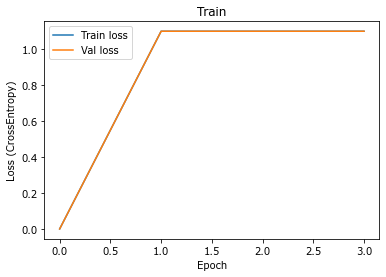

In [10]:
plt.plot(train_loss_list, label='Train loss')
plt.plot(val_loss_list, label='Val loss')
plt.title('Train')
plt.xlabel("Epoch")
plt.ylabel("Loss (CrossEntropy)")
#plt.ylim((0, 2))
plt.legend()  # 顯示標籤

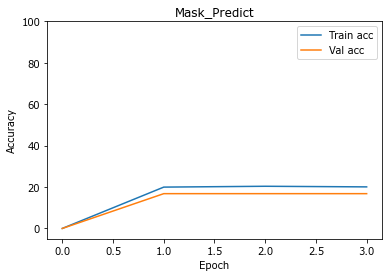

In [11]:
plt.plot(train_acc_list, label='Train acc')
plt.plot(val_acc_list, label='Val acc')
plt.title('Mask_Predict')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim((-5, 100))  # 限制範圍
plt.legend()  # 顯示標籤